In [2]:
import numpy as np
import cv2 as cv
import os
import pickle
import matplotlib.pyplot as plt

stereo_params_dir = 'imgs/videocal/pruebaestereo/calib'
stereo_params_filename = 'calibData.pk'
with open(os.path.join(stereo_params_dir, stereo_params_filename), 'rb') as f:
    stereo_params = pickle.load(f)
    
for k in stereo_params:
    print(k)
    print(stereo_params[k])
    print()

cameraMatrix1
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

cameraMatrix2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

distCoeffs1
[[0. 0. 0. 0. 0.]]

distCoeffs2
[[0. 0. 0. 0. 0.]]

R
[[ 9.99779248e-01 -2.10108391e-02  3.56211486e-06]
 [ 2.10108391e-02  9.99779248e-01  4.12724053e-06]
 [-3.64804530e-06 -4.05148641e-06  1.00000000e+00]]

T
[[-3.55788271e+00]
 [-1.82880742e-01]
 [-2.30475692e-04]]

E
[[ 5.50964490e-06  2.31165753e-04 -1.82880741e-01]
 [-2.43404131e-04 -9.57222576e-06  3.55788271e+00]
 [ 1.08086270e-01 -3.56093977e+00 -1.40327955e-05]]

F
[[-3.92626323e-01 -1.64732503e+01  1.30323813e+04]
 [ 1.73453772e+01  6.82132492e-01 -2.53540551e+05]
 [-7.70240471e+03  2.53758403e+05  1.00000000e+00]]



In [34]:
img2_path = 'imgs/videocal/pruebaestereo/imgs/der/frame_der_0.png'
img1_path = 'imgs/videocal/pruebaestereo/imgs/izq/frame_izq_0.png'

img1 = cv.imread(img1_path)
img2 = cv.imread(img2_path)
R1, R2, P1, P2, Q, validROI1, validROI2 = cv.stereoRectify(stereo_params['cameraMatrix1'],
                                                          stereo_params['distCoeffs1'],
                                                          stereo_params['cameraMatrix2'],
                                                          stereo_params['distCoeffs2'],
                                                          img1.shape[:2][::-1],
                                                          stereo_params['R'],
                                                          stereo_params['T'])

map1x, map1y = cv.initUndistortRectifyMap(stereo_params['cameraMatrix1'],
                                         stereo_params['distCoeffs1'],
                                         R1,
                                         P1,
                                         size = img1.shape[:2][::-1],
                                         m1type = 5)
map2x, map2y = cv.initUndistortRectifyMap(stereo_params['cameraMatrix2'],
                                         stereo_params['distCoeffs2'],
                                         R2,
                                         P2,
                                         size = img2.shape[:2][::-1],
                                         m1type = 5)

x1, y1, w1, h1 = validROI1
x2, y2, w2, h2 = validROI2

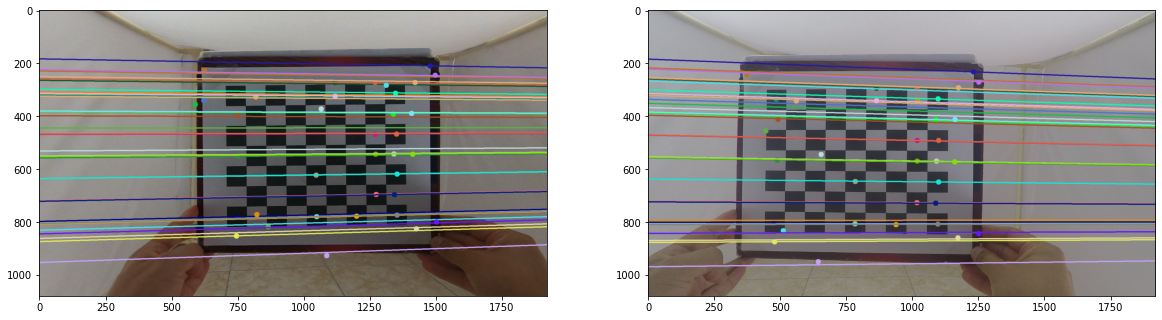

In [47]:
# sift = cv.SIFT_create()
img1_c = img1.copy()
img2_c = img2.copy()
kp1, des1 = sift.detectAndCompute(cv.cvtColor(img1_c, cv.COLOR_BGR2GRAY),None)
kp2, des2 = sift.detectAndCompute(cv.cvtColor(img2_c, cv.COLOR_BGR2GRAY),None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.5*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, stereo_params['F']).reshape(-1,3)
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, stereo_params['F']).reshape(-1,3)

for l1, l2, p1, p2 in zip(lines1, lines2, pts1, pts2):
    color = tuple(np.random.randint(0,255,3).tolist())
    x01, y01 = [0, int(-l1[2]/l1[1])]
    x11, y11 = [img1.shape[1], int(-(l1[2]+l1[0]*img1.shape[1])/l1[1])]
    x02, y02 = [0, int(-l2[2]/l2[1])]
    x12, y12 = [img2.shape[1], int(-(l2[2]+l2[0]*img2.shape[1])/l2[1])]
    cv.line(img1_c, (x01,y01), (x11,y11), color, 3)
    cv.circle(img1_c, tuple(p1), 10, color, -1)
    cv.line(img2_c, (x02,y02), (x12,y12), color, 3)
    cv.circle(img2_c, tuple(p2), 10, color, -1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(cv.cvtColor(img1_c, cv.COLOR_BGR2RGB))
ax2.imshow(cv.cvtColor(img2_c, cv.COLOR_BGR2RGB))
plt.show()

In [48]:
undist1 = cv.remap(img1_c, map1x, map1y, cv.INTER_LINEAR)[y1:y1+h1, x1:x1+w1]
undist2 = cv.remap(img2_c, map2x, map2y, cv.INTER_LINEAR)[y2:y2+h2, x2:x2+w2]

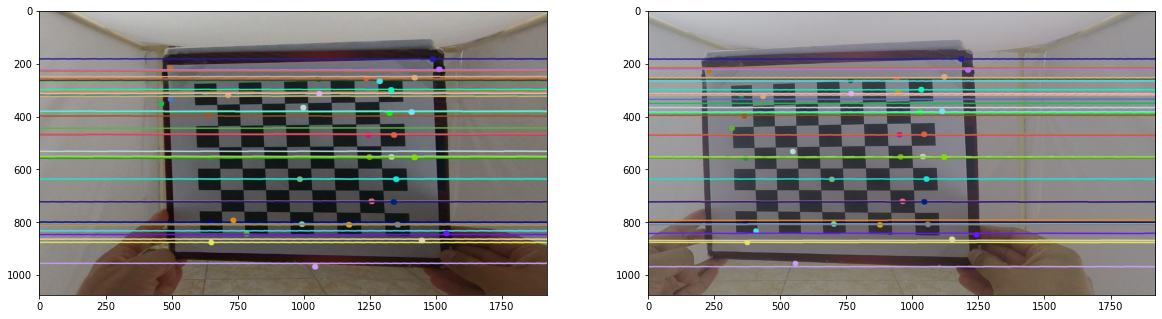

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(cv.cvtColor(undist1, cv.COLOR_BGR2RGB))
ax2.imshow(cv.cvtColor(undist2, cv.COLOR_BGR2RGB))
plt.show()

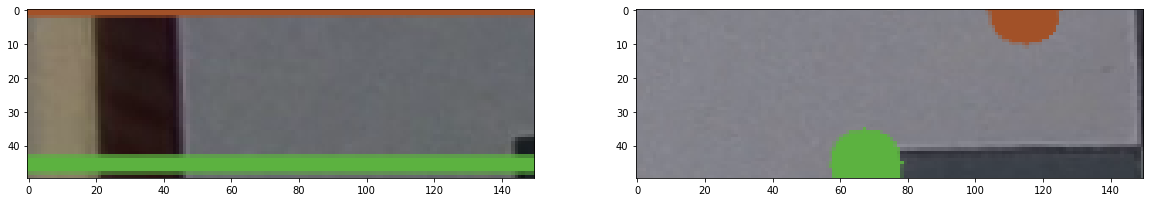

In [50]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(cv.cvtColor(undist1[400:450, 450:600], cv.COLOR_BGR2RGB))
ax2.imshow(cv.cvtColor(undist2[400:450, 250:400], cv.COLOR_BGR2RGB))
plt.show()